In [1]:
# assign directory
import git
from pathlib import Path
import os
ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
os.chdir(os.path.join(ROOT_DIR, "utilities"))
# from transform import *
from transform_audio import *
# from plotting import *
os.chdir(os.path.join(ROOT_DIR, "dataset-preparation"))

data_dir  = os.path.join(ROOT_DIR, 'raw-data', 'ravdess', 'full-ravdess-wav-processed')
# iterate over files in that directory
file_list = [os.path.join(data_dir, filename) for filename in os.listdir(data_dir) if filename != ".DS_Store"]
file_names = os.listdir(data_dir)

In [8]:
max_n = max(map(lambda p: len(wavfile.read(p)[1]), file_list))
max_n

160256

In [9]:
transform_list(fft_file, file_list, file_names, n=max_n)

Computing and exporting coefficients:   0%|          | 0/1440 [00:00<?, ?it/s]

# Fourier Representation

In [6]:
import numpy as np
import pywt
import matplotlib.pyplot as plt
from scipy.io import wavfile
import librosa

In [7]:
ravdess_df = pd.read_csv(os.path.join(ROOT_DIR, "raw-data", "ravdess", 'full-ravdess.csv'))

In [8]:
test_file_idx = 42
print(ravdess_df.iloc[test_file_idx])

rate, signal1 = wavfile.read(file_list[test_file_idx])
signal2, rate_l = librosa.load(file_list[test_file_idx], sr=None)

Unnamed: 0                                           42
modality                                     audio-only
channel                                          speech
emotion                                         neutral
intensity                                        normal
statement                  Kids are talking by the door
repetition                                            2
actor                                                19
sex                                                male
filename                       03-01-01-01-01-02-19.wav
length (s)                                        1.344
rate (Hz)                                         48000
amplitudes    [ 2012  1486   232 ... -6685 -6556 -7419]
Name: 42, dtype: object


In [9]:
print(rate == rate_l)
print(signal1 / signal2)
# just scaled down by 2**15 (normalized by maximumum signal)
signal = signal2

True
[32768. 32768. 32768. ... 32768. 32768. 32768.]


C:\Users\Henry\AppData\Local\Temp\ipykernel_37832\1270320814.py:2: RuntimeWarning: invalid value encountered in divide
  print(signal1 / signal2)


In [10]:
fft_signal = np.fft.fft(signal)
frequencies = np.fft.fftfreq(len(signal), 1/rate)

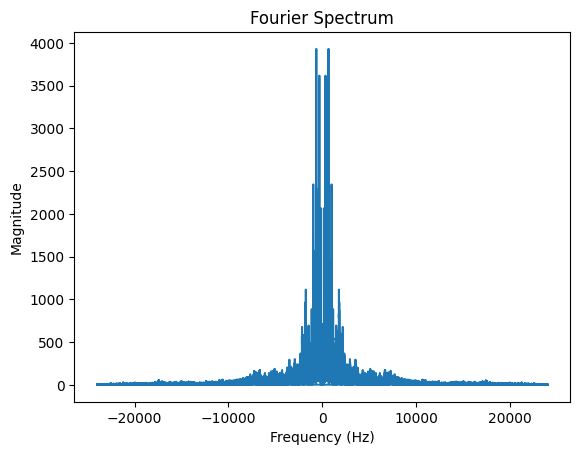

In [11]:
plt.plot(frequencies, np.abs(fft_signal))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.title('Fourier Spectrum')
plt.show()

In [12]:
negative_idx = len(frequencies) // 2 # first half nonnegative, second half negative
assert negative_idx == (frequencies < 0).argmax()
assert (frequencies[1:negative_idx] == -frequencies[negative_idx + 1:][::-1]).all() # exclude one negative due to parity mismatch
positive_signals = fft_signal[1:negative_idx]
negative_signals = fft_signal[negative_idx + 1:][::-1]
assert ((positive_signals + negative_signals).imag == 0).all() # all real
print(positive_signals)
print(negative_signals)

[ 166.45377  +452.9518j       89.94155  -233.22443j
 -490.63513  +108.84839j    ...   -0.9668803  +2.7040968j
    1.1774989  +0.69995975j    3.9380465  -0.6990689j ]
[ 166.45377  -452.9518j       89.94155  +233.22443j
 -490.63513  -108.84839j    ...   -0.9668803  -2.7040968j
    1.1774989  -0.69995975j    3.9380465  +0.6990689j ]


In [13]:
def fft_file(filename, visualize=False, title='Fourier Spectrum'):
    rate, signal = librosa.load(os.path.join(data_dir, filename), sr=None)
    fft_signal = np.fft.fft(signal)
    frequencies = np.fft.fftfreq(len(signal), 1/rate)

    if visualize:
        plt.plot(frequencies, np.abs(fft_signal))
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Magnitude')
        plt.title(title)
        plt.show()
    
    return fft_signal, frequencies

## Frequency band grouping

In [2]:
transform_dir = os.path.join(ROOT_DIR, 'raw-data', 'ravdess', 'ravdess-transforms')
coefs_npz_path = os.path.join(transform_dir, 'fft_coefs.npz')

In [3]:
bands = freq_band_groupings(
    coefs_npz_path=coefs_npz_path,
    ks_threshold=0.05,
)

In [4]:
bands

[(0, 1),
 (1, 2),
 (2, 3),
 (3, 4),
 (4, 9),
 (9, 19),
 (19, 29),
 (29, 39),
 (39, 58),
 (58, 78),
 (78, 117),
 (117, 156),
 (156, 313),
 (313, 469),
 (469, 547),
 (547, 626),
 (626, 1252),
 (1252, 1878),
 (1878, 2504),
 (2504, 5008),
 (5008, 6260),
 (6260, 7512),
 (7512, 10016),
 (10016, 20032),
 (20032, 40064),
 (40064, 45072),
 (45072, 50080),
 (50080, 55088),
 (55088, 60096),
 (60096, 70112),
 (70112, 80128)]

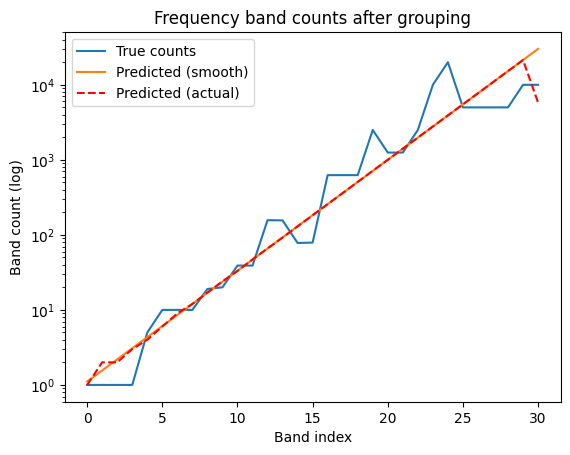

[(0, 1),
 (1, 3),
 (3, 5),
 (5, 8),
 (8, 12),
 (12, 18),
 (18, 27),
 (27, 39),
 (39, 56),
 (56, 80),
 (80, 113),
 (113, 160),
 (160, 226),
 (226, 318),
 (318, 448),
 (448, 631),
 (631, 888),
 (888, 1249),
 (1249, 1757),
 (1757, 2470),
 (2470, 3472),
 (3472, 4881),
 (4881, 6861),
 (6861, 9644),
 (9644, 13554),
 (13554, 19050),
 (19050, 26773),
 (26773, 37628),
 (37628, 52883),
 (52883, 74322),
 (74322, 80128)]

In [5]:
geometric_count_bands(bands, visualize=True)

$$\log(g_i) = \theta_0 + \theta_1 i \\
g_i = e^{\theta_0} e^{\theta_1 i} = \alpha \cdot \beta^i \\
\alpha = e^{\theta_0}, \ \beta = e^{\theta_1}$$